# Detect Noisy channels

In [ ]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from pyprep.find_noisy_channels import NoisyChannels
subject = 602
# Add the workspace root to the Python path
workspace_root = os.path.abspath("../..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess

# Load the bridged channels data
with open(os.path.join(workspace_root, 'Data', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)
    bridged_channels= all_bridged_channels[subject] # either 5 or 16 ; 16 is a stricter threshold

print('Bridged channels:', bridged_channels['bridged_ch_names'])

Bridged channels: ['A1', 'A2', 'A6', 'A7', 'A17', 'A18', 'A20', 'A21', 'A23', 'A24', 'A28', 'A29', 'A30', 'A31', 'B15', 'B16', 'B17', 'B18', 'C18', 'C19', 'C20', 'C26', 'C27', 'D18', 'D19']


In [2]:
sub = preprocess(subject)
raw = sub.load_data()
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 40)

Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_602_Def_MM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449535  =      0.000 ...   877.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_602_Def_MM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449535  =      0.000 ...   877.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


<RawEDF | O_602_Def_MM.bdf, 129 x 449536 (878.0 s), ~442.6 MiB, data loaded>

In [3]:
events = mne.find_events(raw)
all_events = sub.get_all_events_times(subject, events)
all_events
all_events = all_events.dropna()
all_trials = []
for idx, row in all_events.iterrows():
    Tnum = row['Trial']
    data = raw.copy().crop(row['defOnset']-0.2, row['Respons'] + 0.2)
    all_trials.append(data)
new_raw = mne.concatenate_raws(all_trials)
new_raw.resample(256)
all_events

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]


92 events found on stim channel Status
Event IDs: [1 2]
92 events found on stim channel Status
Event IDs: [1 2]


,Trial,defOnset,SecWordOnset,LWOnset,Respons
0,1,3.813994,4.788994,5.427994,6.145547
1,2,11.272050,12.100050,12.819050,13.875859
3,4,26.871100,27.497100,28.365100,29.207812
4,5,33.859033,34.635033,37.025033,37.895938
5,6,42.818063,43.491063,45.034063,46.122031
...,...,...,...,...,...
103,104,832.570877,833.096877,833.996877,835.291172
104,105,840.429684,840.822684,842.633684,844.041934
105,106,848.851848,849.443848,851.570848,852.612891
106,107,857.377148,857.844148,858.944148,860.475406


In [4]:
from pyprep.find_noisy_channels import NoisyChannels
det = NoisyChannels(new_raw, do_detrend=False)
det.find_all_bads(ransac=False)
bad_ch = det.get_bads(as_dict=True)
bad_ch

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': [],
 'bad_by_hf_noise': [],
 'bad_by_correlation': ['A5', 'A32'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['A5', 'A32']}

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


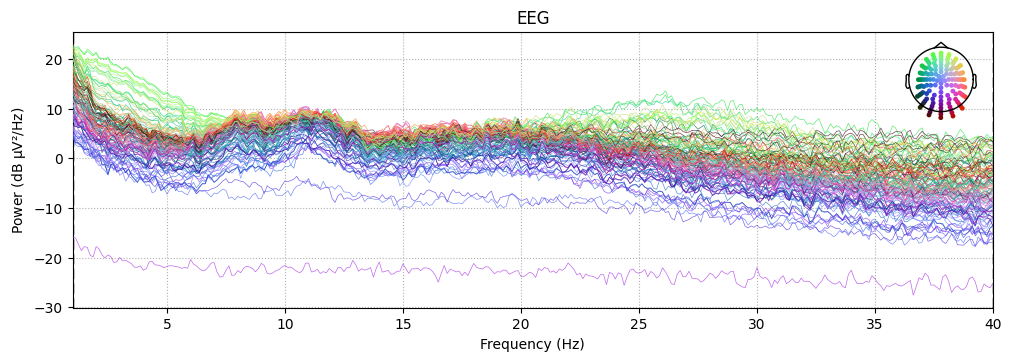

In [6]:
%matplotlib qt
new_raw.plot_psd(fmin = 1, fmax = 40)

Channels marked as bad:
none


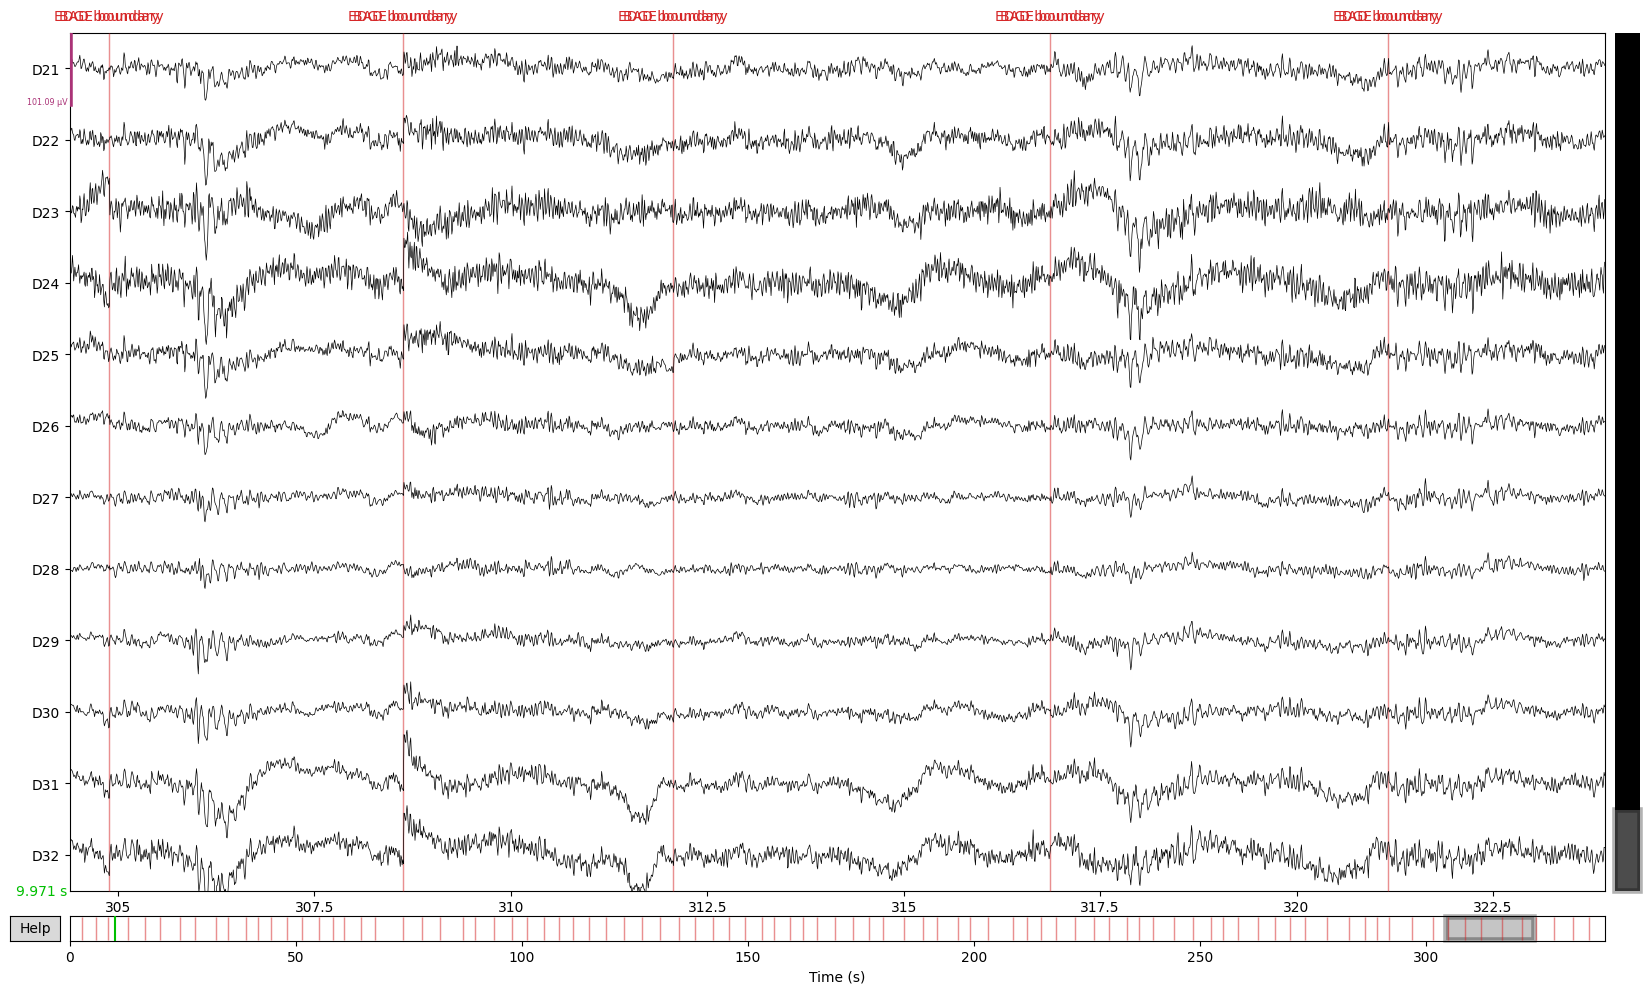

In [8]:
%matplotlib qt 
new_raw.plot(use_opengl=True, block=True, n_channels=10, scalings=dict(eeg=10e-6), picks = 'eeg', duration = 10)


# find noisy Trials

In [9]:
import mne

all_events = all_events.dropna()
all_trials = []
annotations = []

for idx, row in all_events.iterrows():
    Tnum = int(row['Trial'])
    start = row['defOnset'] - 0.2
    end = row['Respons'] + 0.2
    duration = end - start

    # Copy and crop raw data
    data = raw.copy().crop(start, end)
    
    # Create annotation
    onset_in_cropped = 0  # onset relative to start of cropped data
    annotation = mne.Annotations(onset=[onset_in_cropped],
                                 duration=[duration],
                                 description=[f'Trial {Tnum}'])
    
    # Set annotation to this segment
    data.set_annotations(annotation)

    all_trials.append(data)

# Concatenate all trials with annotations
new_raw = mne.concatenate_raws(all_trials)

# Check annotations
print(new_raw.annotations)

<Annotations | 274 segments: BAD boundary (91), EDGE boundary (91), Trial ...>


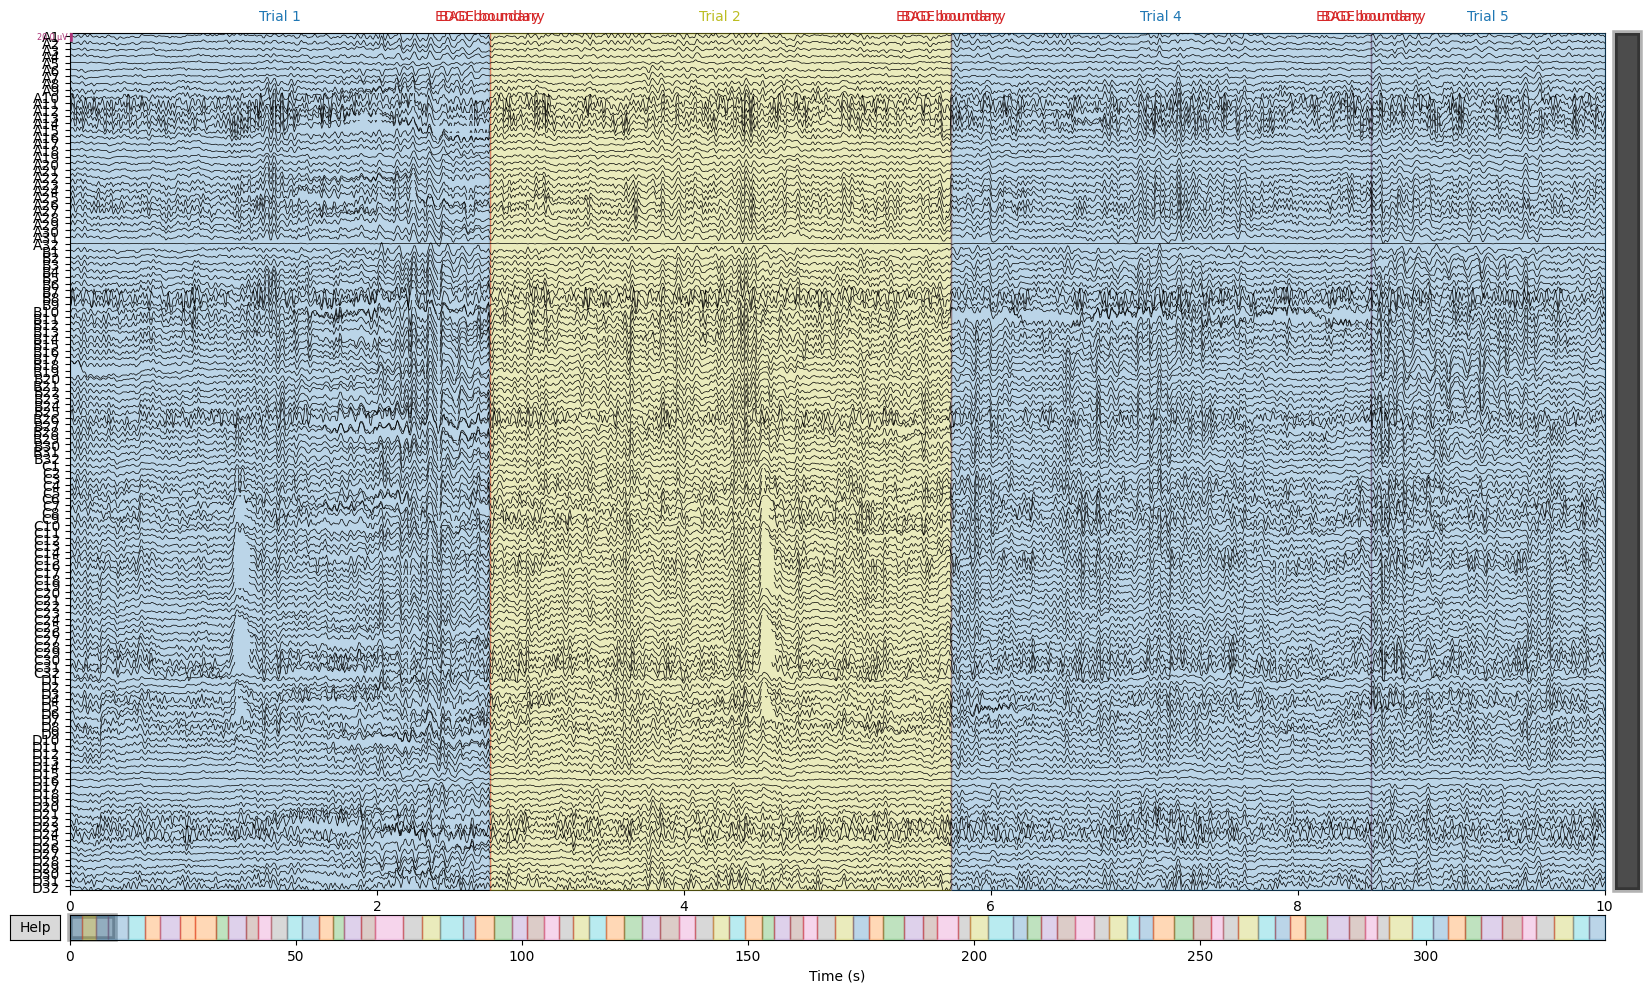

Channels marked as bad:
none


In [10]:
%matplotlib qt
new_raw.plot( n_channels=128, scalings=dict(eeg=10e-6), picks = 'eeg', duration = 10)

In [2]:
# load the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "rb") as f:
    detected_noise = pickle.load(f)
detected_noise[subject] = {'channel_names': ['A32'],
                           'trial_numbers': [19,17, 20, 62 ,69,  71 ,75, 77, 78]}
# save the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "wb") as f:
    pickle.dump(detected_noise, f)